In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline

RFM Analysis
============
In this ipynb file, We aim to create columns below
- customer_unique_id: unique key
- recency: days since last purchase
- frequency: number of purchases
- monetary: total amount of purchases
- recency_cluster
- frequency_cluster
- monetary_cluster
- overall_score: sum or product of recency_cluster, frequency_cluster, monetary_cluster

Used clustering algorithm
- KMeans

In [4]:
## Use 3 datasets
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')
df_order_payments = pd.read_csv('../datasets/olist_order_payments_dataset.csv')

In [5]:
## Merge datasets
df = pd.merge(df_orders, df_customers, on='customer_id') ## Memo: 'customer_id' is foreign key, not unique

order_payments = df_order_payments.groupby('order_id').agg({'payment_value': 'sum'}).reset_index()
df = pd.merge(df, order_payments, on='order_id')
print(f"df_orders: {df_orders.shape}")
print(f"df_customers: {df_customers.shape}")
print(f"df: {df.shape}")

df_orders: (99441, 8)
df_customers: (99441, 5)
df: (99440, 13)


In [6]:
df.describe()

,customer_zip_code_prefix,payment_value
count,99440.000000,99440.000000
mean,35137.681114,160.990267
std,29798.017652,221.951257
min,1003.000000,0.000000
25%,11347.000000,62.010000
50%,24416.000000,105.290000
75%,58900.000000,176.970000
max,99990.000000,13664.080000


In [7]:
print(f"{df[df['payment_value'] == 0].shape[0]} rows are deleted.")
df.drop(df[df['payment_value'] == 0].index, inplace=True)

3 rows are deleted.


In [8]:
## datatypes for each column
df.dtypes

## some data objects should be converted to datetime

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
payment_value                    float64
dtype: object

In [9]:
## Convert data object to datetime
df_columns = [
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in df_columns:
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Feature Engineering
Create new features from the original dataset

In [10]:
## order purchase year, month, day, hour
# df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
# df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
# df['order_purchase_day'] = df['order_purchase_timestamp'].dt.day ## We can delete this column because we have day_of_week
# df['order_purchase_hour'] = df['order_purchase_timestamp'].dt.hour

## order purchase dayofweek
# df['order_purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek. \
#     map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

# df['delivery_ahead_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

## Todo: add more features


## Recency

In [11]:
## We use df_rfm for Recency, Frequency, Monetary
df_rfm = pd.DataFrame(df['customer_unique_id'])
df_rfm.columns = ['customer_unique_id']

## Get the latest purchase date for each customer
df_latest_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days

## Merge Recency to df_rfm
df_rfm = df_rfm.merge(df_latest_purchase, on='customer_unique_id')

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380
2,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,84
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,70
4,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,332


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_45133/2131498726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

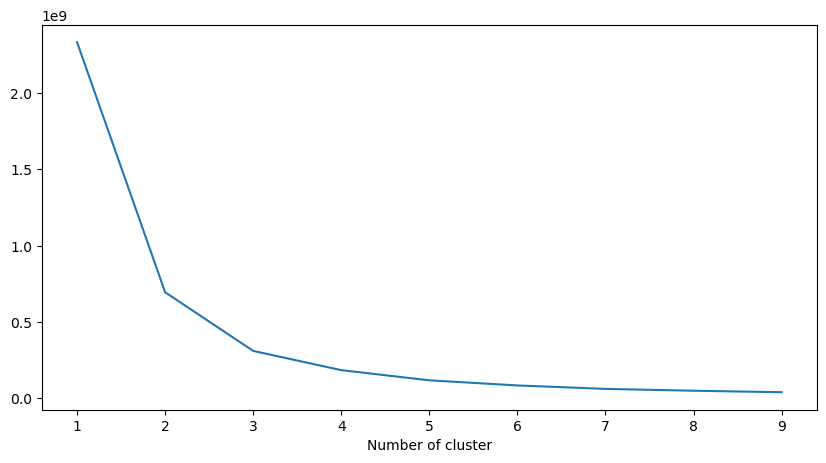

In [12]:
## Use k-means to get recency_cluster
## First of all, we need to know the optimal number of clusters
sse={}
df_recency = df_rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [13]:
## The plot shows that the optimal number is 4 or 5. We choose 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['recency']])
df_rfm['recency_cluster'] = kmeans.predict(df_rfm[['recency']])

# recency_cluster's number is not meaningful, we need to change it to meaningful number
def order_cluster(cluster_column_name, target_column_name, df, ascending=False):
    df_tmp = df.groupby(cluster_column_name)[target_column_name].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=target_column_name, ascending=ascending).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index + 1 ## plus 1 because we don't want to start from 0. We may multiply 3 clusters for overall score

    df_output = pd.merge(
        df,
        df_tmp[[cluster_column_name, 'index']],
        on=cluster_column_name
    )
    df_output = df_output.drop([cluster_column_name], axis=1)
    df_output = df_output.rename(columns = {"index": cluster_column_name})
    return df_output

df_rfm = order_cluster('recency_cluster', 'recency', df_rfm)

df_rfm.groupby('recency_cluster')['recency'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
1,17773.0,533.091993,59.794792,448.0,485.0,524.0,575.0,772.0
2,25886.0,362.723519,43.246252,298.0,325.0,356.0,399.0,447.0
3,28780.0,232.339680,35.069877,172.0,203.0,232.0,263.0,297.0
4,26998.0,110.468331,36.127167,0.0,77.0,110.0,144.0,171.0


In [14]:
## The count and mean values show the recency_cluster is meaningful


## Frequency

In [15]:
df_frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_frequency.columns = ['customer_unique_id', 'frequency']

## Merge Frequency to df_rfm
df_rfm = df_rfm.merge(df_frequency, on='customer_unique_id')

df_rfm['frequency'].describe()

count    99437.000000
mean         1.079206
std          0.396140
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: frequency, dtype: float64

In [16]:
## The table above shows that most customers ordered only once.

# count the number that frequency is more than 1
repeater_nu = df_frequency[df_frequency['frequency'] > 1].shape[0]
repeater_ratio = repeater_nu / df_frequency.shape[0]
print('The number of repeater:', repeater_nu)
print('The ratio of repeater:', repeater_ratio)

The number of repeater: 2996
The ratio of repeater: 0.031178129520360483


In [17]:
## Create 2 clusters, ordered more than once(2)? or only once(1)?
df_rfm['frequency_cluster'] = np.where(df_rfm['frequency'] > 1, 2, 1)
df_rfm.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
1,93097.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,6340.0,2.242271,1.008238,2.0,2.0,2.0,2.0,17.0


## Monetary

In [18]:
df_monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()

df_rfm = df_rfm.merge(df_monetary, on='customer_unique_id')

df_monetary.describe()

,payment_value
count,96093.000000
mean,166.597693
std,231.430072
min,9.590000
25%,63.130000
50%,108.000000
75%,183.530000
max,13664.080000


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_45133/1291469255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

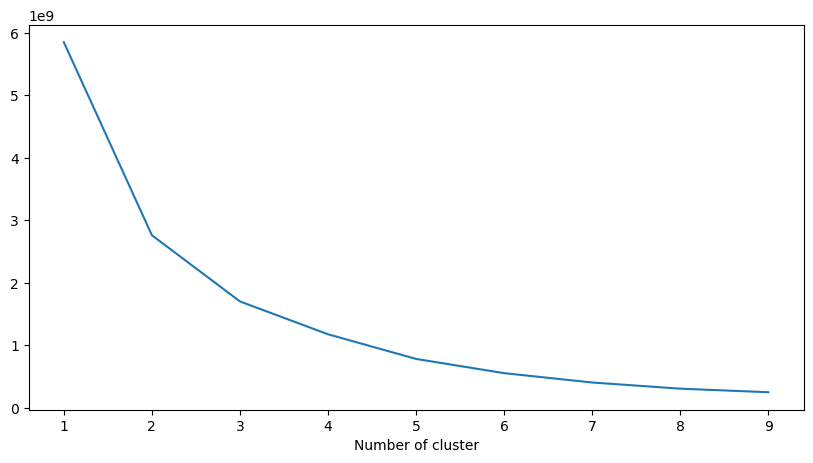

In [19]:
## Use k-means
sse={}
df_revenue = df_rfm[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [20]:
## The plot shows that the optimal number is 4, 5, or 6. We choose 5.
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['payment_value']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['payment_value']])


#order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'payment_value', df_rfm)

#show details of the dataframe
df_rfm.groupby('monetary_cluster')['payment_value'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,11.0,8309.181818,2162.604468,6081.54,6925.76,7571.63,9553.02,13664.08
2,281.0,2488.456192,659.430887,1877.84,2032.00,2223.12,2734.66,4809.44
3,1209.0,1265.497179,244.220711,942.78,1053.74,1223.06,1426.58,1872.26
4,4723.0,619.405075,137.686797,437.18,500.60,596.76,715.62,941.12
5,22929.0,254.519063,69.833487,170.64,196.50,233.61,301.65,437.08
6,70284.0,86.577145,40.347442,9.59,52.91,80.90,117.85,170.63


In [21]:
## Most cusotmers in the cluster 6.
## So I use log transformation, and recreate the clusters.

## Remove monetary_cluster column
# df_rfm = df_rfm.drop('monetary_cluster', axis=1)

# Apply log transformation
df_rfm['monetary_log'] = np.log(df_rfm['payment_value'])
df_rfm['monetary_log'].describe()


count    99437.000000
mean         4.748725
std          0.830129
min          2.260721
25%          4.160444
50%          4.713935
75%          5.244706
max          9.522526
Name: monetary_log, dtype: float64

In [22]:
# Run K-means on the transformed data
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['monetary_log']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['monetary_log']])

# Order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'monetary_log', df_rfm, True)

# Show details of the dataframe
df_rfm.groupby('monetary_cluster')['monetary_log'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,13952.0,3.541552,0.233716,2.260721,3.407428,3.587262,3.731699,3.848444
2,22173.0,4.152943,0.158403,3.848657,4.024458,4.164182,4.289363,4.418117
3,24603.0,4.681900,0.150102,4.418238,4.554719,4.682131,4.810557,4.936055
4,22403.0,5.192489,0.158812,4.936199,5.057837,5.176997,5.324521,5.504111
5,11880.0,5.820751,0.215149,5.504193,5.634066,5.791091,5.981389,6.301098
6,4426.0,6.786571,0.419305,6.301226,6.460472,6.670944,7.002069,9.522526


## Overall Score
We can create two types of overall score
1. Sum of recency, frequency, and monetary
2. Product of recency, frequency, and monetary

### 1. Overall Score (sum)

In [23]:
## Now, we have recency_cluster, and monetary_cluster. Let's get the overall RFM Score.
df_rfm['overall_score_sum'] = df_rfm['recency_cluster'] + df_rfm['frequency_cluster'] + df_rfm['monetary_cluster']

In [24]:
df_rfm.groupby('overall_score_sum')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_sum,,,
3,536.368980,1.000000,3.543045
4,453.309421,1.002365,3.878735
5,376.517919,1.005834,4.135371
6,306.940222,1.015199,4.389520
7,264.326632,1.033141,4.766876
8,224.712692,1.070248,5.148845
9,186.582653,1.155851,5.523845
10,159.952133,1.335670,5.976495
11,125.584396,1.721061,6.448323


In [25]:
df_rfm.groupby('overall_score_sum')['overall_score_sum'].count()

overall_score_sum
3      2637
4      7611
5     14398
6     19606
7     20096
8     16940
9     10895
10     4993
11     1961
12      300
Name: overall_score_sum, dtype: int64

In [26]:
## Segment customers based on their overall_score_sum
## We can change the threshold values
df_rfm['segment_sum'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 7,'segment_sum'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 9,'segment_sum'] = 'High-Value'

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency,recency_cluster,frequency,frequency_cluster,payment_value,monetary_log,monetary_cluster,overall_score_sum,segment_sum
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380,2,2,2,82.82,4.416670,2,6,Low-Value
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380,2,2,2,82.82,4.416670,2,6,Low-Value
2,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,332,2,1,1,72.20,4.279440,2,5,Low-Value
3,37363700139c1aef873bbcd916e57dfd,2017-12-12 13:56:04,309,2,1,1,63.10,4.144721,2,5,Low-Value
4,9d9ab3b77f0416765b3fbedf94a942a4,2017-08-31 08:15:24,412,2,1,1,50.25,3.917011,2,5,Low-Value


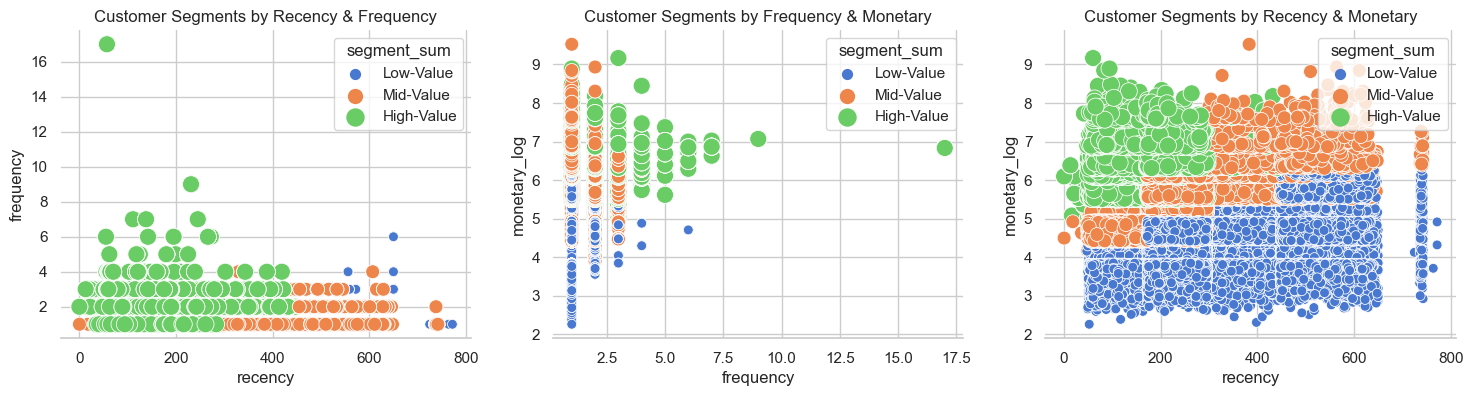

In [27]:
## Visualization: Customer Semgments, using 'egment_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_sum', data=df_rfm, size='segment_sum', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

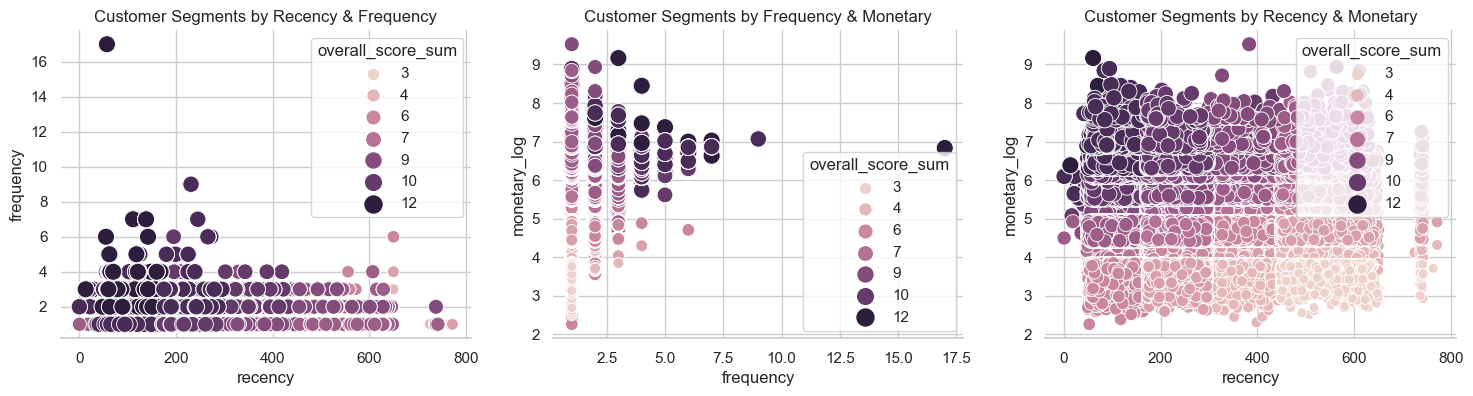

In [28]:
## Visualization: Customer Semgments, using 'overall_score_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_sum', data=df_rfm, size='overall_score_sum', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### Overall Score (product)

In [29]:
df_rfm['overall_score_product'] = df_rfm['recency_cluster'] * df_rfm['frequency_cluster'] * df_rfm['monetary_cluster']

df_rfm.groupby('overall_score_product')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_product,,,
1,536.368980,1.000000,3.543045
2,453.309421,1.002365,3.878735
3,383.733772,1.000000,4.115539
4,340.442781,1.006383,4.261075
5,539.079602,1.000000,5.818468
6,312.048053,1.017167,4.535543
8,237.445256,1.033318,4.650918
9,232.859147,1.000000,4.679748
10,374.725614,1.103158,5.809797


In [30]:
df_rfm.groupby('overall_score_product')['overall_score_product'].count()

overall_score_product
1      2637
2      7611
3      8365
4     13160
5      1809
6     13048
8     11225
9      6773
10     2850
12    14030
15     2731
16     6211
18     1268
20     3112
24     2094
30      651
32      581
36      254
40      727
48      300
Name: overall_score_product, dtype: int64

In [31]:
## Segment customers based on their overall_score_product
## We can change the threshold values
df_rfm['segment_product'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 10, 'segment_score'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 24,'segment_score'] = 'High-Value'

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency,recency_cluster,frequency,frequency_cluster,payment_value,monetary_log,monetary_cluster,overall_score_sum,segment_sum,overall_score_product,segment_product,segment_score
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380,2,2,2,82.82,4.416670,2,6,Low-Value,8,Low-Value,NaN
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,380,2,2,2,82.82,4.416670,2,6,Low-Value,8,Low-Value,NaN
2,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,332,2,1,1,72.20,4.279440,2,5,Low-Value,4,Low-Value,NaN
3,37363700139c1aef873bbcd916e57dfd,2017-12-12 13:56:04,309,2,1,1,63.10,4.144721,2,5,Low-Value,4,Low-Value,NaN
4,9d9ab3b77f0416765b3fbedf94a942a4,2017-08-31 08:15:24,412,2,1,1,50.25,3.917011,2,5,Low-Value,4,Low-Value,NaN


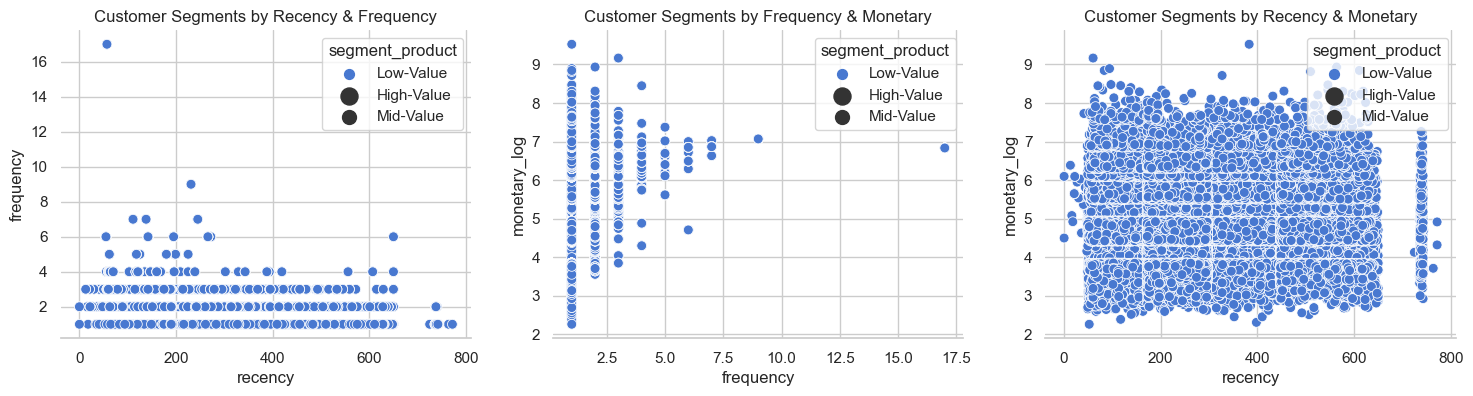

In [32]:
## Visualization: Customer Semgments, using 'segment_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_product', data=df_rfm, size='segment_product', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

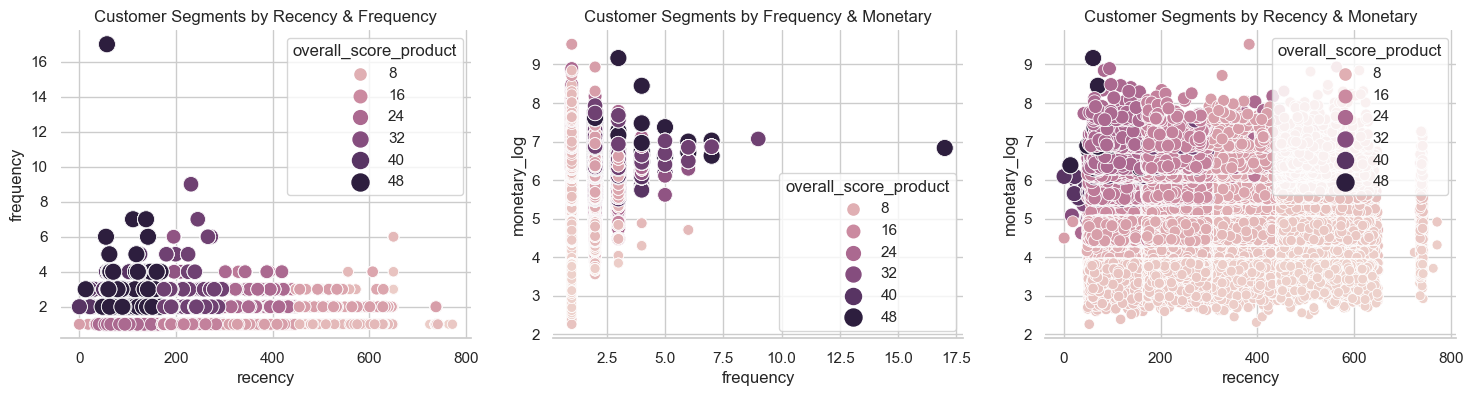

In [33]:
## Visualization: Customer Semgments, using 'overall_score_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_product', data=df_rfm, size='overall_score_product', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### TODO (optional)
We can calculate overall score by weighting each feature differently.
For example, we can give more weight to recency than frequency and monetary.